# Data Wrangling (Limpieza de datos)  
## Actividad 7   
### Enunciado  
  1. Se debería realizar una limpieza de problemas (outliers, duplicados, valores nulos).  
  2. En caso de existir valores nulos decidir si se puede utilizar alguna técnica de imputación ya sea sensible o múltiple.  
  3. Se deberán resolver el problema de outliers, para esto se deberá generar una estrategia de identificación ya sea con métodos tradicionales (IQ, Z score, etc) o utilizando aprendizaje de máquina (Isolation Forest, LoF,SVM one Class, etc).

# Desarrollo

## Planificación
Se planea hacer una limpieza de datos usando la siguiente secuencia:  
    1. Se buscarán valores nulos  
    2. Se verificará el porcentaje de valores nulos.  
    3. Si la cantidad de valores nulos es significativo, se descartarán dichos datos. Sino, se tratarán de llenar con algún método conocido.  
    4. Una vez tratados los nulos, se tratarán los outliers. 

### Diseño  
Los datos de interés para los futuros modelos serán los siguientes:  
Primera linea, variables con interés relacionadas a la retención del usuario:  
    - Score: Variable de interés principal  
    - Genres: Variable de comparación  
    - Producers: Variable de comparación  
    - Studios: Variable de comparación  
    - Ranked: Variable relevante  
    - Popularity: Variable relevante  
    - Rating: Variable relevante  
    - Favorites: Variable relevante  
    - Type: Variable relevante  
      
Segunda linea, variables con interés a la fidelidad del usuario y el tiempo dedicado:  
    - Score: Variable relevante  
    - Duration: Variable relevante  
    - Episodes: Variable relevante  
    - Watching: Variable relevante  
    - Completed: Variable relevante  
    - On-Hold: Variable relevante  
    - Dropped: Variable relevante  


## Desarrollo técnico

Inicialización

In [243]:
import warnings
import pandas as pd
#import missingno as msn 
from fancyimpute import IterativeImputer
from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [154]:
#Lectura del archivo y confirmación de contenido

tabla=pd.read_csv('anime.csv',sep=',',encoding='utf-8')
tabla.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [155]:
#Separación de los datos de interés 
data1 = tabla[['Name','Score', 'Genres', 'Producers', 'Studios','Ranked','Popularity','Rating','Favorites','Type']].copy()
data2 = tabla[['Name','Score', 'Duration', 'Episodes', 'Watching','Completed','On-Hold','Dropped']].copy()

In [156]:
#Se verifica que no tenga nulos
print('Primera linea:')
print(data1.isnull().sum())
print('Segunda linea:')
print(data2.isnull().sum())

Primera linea:
Name          0
Score         0
Genres        0
Producers     0
Studios       0
Ranked        0
Popularity    0
Rating        0
Favorites     0
Type          0
dtype: int64
Segunda linea:
Name         0
Score        0
Duration     0
Episodes     0
Watching     0
Completed    0
On-Hold      0
Dropped      0
dtype: int64


Sin embargo, gracias al análisis exploratorio de datos, se sabe que no hay valores nulos, pero si se encuentran valores "unknown". En el caso actual, serian equivalentes. Por lo tanto, hay que trabajar los datos unknown. 

In [157]:
nulos = data1.apply(lambda row: row.astype(str).str.contains('Unknown').any(), axis=1).sum()
print('Cantidad de filas que presentan nulos: '+str(nulos))
print('Porcentaje de filas que presentan nulos:')
print((nulos/len(data1))*100)

Cantidad de filas que presentan nulos: 12190
Porcentaje de filas que presentan nulos:
69.41122878943172


In [158]:
nulos = data2.apply(lambda row: row.astype(str).str.contains('Unknown').any(), axis=1).sum()
print('Cantidad de filas que presentan nulos: '+str(nulos))
print('Porcentaje de filas que presentan nulos:')
print((nulos/len(data1))*100)

Cantidad de filas que presentan nulos: 5266
Porcentaje de filas que presentan nulos:
29.985195308051477


En ambos casos es un porcentaje considerable, por lo que no es bueno perder tanta información.  
Se procede a reemplazar los datos.  
Se escogido **la imputación multiple o predictiva** porque son demasiados nulos.  

¿Donde se encuentran exactamente estos nulos disfrazados de Unknown? 

In [159]:
null = {} #Se crea diccionario para almacenar los unknowns
for i in data1.columns: #Por cada columna
    null[i] = int((data1[i].values == 'Unknown').sum()) #Se obtiene la cantidad de Unknowns
print(null)

{'Name': 0, 'Score': 5141, 'Genres': 63, 'Producers': 7794, 'Studios': 7079, 'Ranked': 1762, 'Popularity': 0, 'Rating': 688, 'Favorites': 0, 'Type': 37}


In [160]:
null = {} #Se crea diccionario para almacenar los unknowns
for i in data2.columns: #Por cada columna
    null[i] = int((data2[i].values == 'Unknown').sum()) #Se obtiene la cantidad de Unknowns
print(null)

{'Name': 0, 'Score': 5141, 'Duration': 555, 'Episodes': 516, 'Watching': 0, 'Completed': 0, 'On-Hold': 0, 'Dropped': 0}


### **Procesamiento previo de los datos** 
Tomado de actividades anteriores

In [161]:
warnings.filterwarnings("ignore")
#Primera linea 
#Pasando de lista separada por comas a listas estructuradas
def deconstruir(line): #Linea base
  if (line == 'Unknown'): #Si es desconocido, se deja igual. 
      return 'Unknown'
  else:
    temp = line.split(",") #Se separa en una lista separada por comas
    return temp

#Procesando
for i in range(len(data1)): #por cada fila
  data1['Genres'][i] = deconstruir(data1['Genres'][i])
  data1['Producers'][i] = deconstruir(data1['Producers'][i])
  data1['Studios'][i] = deconstruir(data1['Studios'][i])

In [162]:
warnings.filterwarnings("ignore")
#Segunda linea
#Método para procesar el tiempo de duración a float
def procesarDateToFloat(line, episodes): #Se recibe la linea base a procesar y la cantidad de episodios
  if (line == 'Unknown'): #Si es desconocido, se deja igual. 
      return 'Unknown'
  else:
      if (episodes == 'Unknown'): #Si no se sabe cuantos episodios tuvo
          epis = 0 #Se asume que tuvo al menos uno
      else: #Sino 
          epis = int(episodes) #Se usa el número de episodios
      #Deconstruimos si es necesario entre los que se encuentren
      dur = line.split(" ")
      duration = 0 #Variable para colocar la duración en minutos
            #Hay varios casos aquí: 
            #1 Cuando es en segundos "x sec."
            #2 Cuando es en segundos por episodios "x sec. per ep."
            #3 Cuando es en minutos "x min."
            #4 Cuando es en minutos por episodios "x min. per ep."
            #5 Cuando es en horas "x hr."
            #6 Cuando es en horas y minutos "x hr. x min."

      if dur[1] == "sec.": #Si es por segundos
            duration = float(dur[0]) / 60 #Se divide el valor en 60 para volverlo minutos. 
            #Queda validado caso 1
      elif dur[1] == "min.": #Sino, se valida si es por minutos
            duration = float(dur[0]) #Se deja el valor en minutos
            #Queda validado caso 3
      else: #Sino, es por horas
            duration = float(dur[0]) * 60 #Se multiplica el valor por 60 para volverlo minutos
            #Queda validado caso 5

      if len(dur) > 2: #Si el tamaño es mayor a 2, es porque es una duración compuesta
            if dur[-1] == "ep.": #Si se divide por episodios, se validan casos 2 y 4
                  duration = duration * epis #Se multiplica por la cantidad de episodios
                  #Quedan validados casos 2 y 4
            elif dur[-1] == "min.": #Si se divide en horas y minutos, se valida caso 6
                  duration = duration + float(dur[2]) #Se suman los minutos
      return duration
  
for i in range(len(data2)): #Por cada fila
     data2['Duration'][i] = procesarDateToFloat(data2['Duration'][i], data2['Episodes'][i])

Para la primera linea: Ahora se tienen los valores categoricos en una lista estructurada para trabajar mejor.  
Para la segunda linea: Ahora se tiene la duración total del anime en minutos. 
  
Se va a tomar los valores 'Unknown' y volvernos valores nulos para poder trabajar adecuadamente con ellos. 

In [163]:
for i in data1.columns: #Por cada columna
    data1[i] = data1[i].apply(lambda x: x if x != 'Unknown' else np.nan) #Se cambia los valores Unknown por NaN

In [164]:
for i in data2.columns: #Por cada columna
    data2[i] = data2[i].apply(lambda x: x if (x != 'Unknown') else np.nan) #Se cambia los valores Unknown por NaN
    data2[i] = data2[i].apply(lambda x: x if (x != 0) else np.nan) #Se cambia los valores 0 por NaN

In [165]:
data1.isnull().sum() #Ver los nulos de las filas

Name             0
Score         5141
Genres          63
Producers     7794
Studios       7079
Ranked        1762
Popularity       0
Rating         688
Favorites        0
Type            37
dtype: int64

In [166]:
data2.isnull().sum() #Ver los nulos de las filas

Name            0
Score        5141
Duration      555
Episodes      516
Watching      357
Completed     531
On-Hold       871
Dropped       376
dtype: int64

Ahora si podemos trabajar con valores nulos. 

In [167]:
#Imputación multiple para la segunda linea
mice_impute = IterativeImputer()
data2fill = mice_impute.fit_transform(data2[['Score','Duration','Episodes','Watching','Completed','On-Hold','Dropped']])
data2fillDF= pd.DataFrame(data2fill)

Text(0.5, 1.0, 'Modificacion')

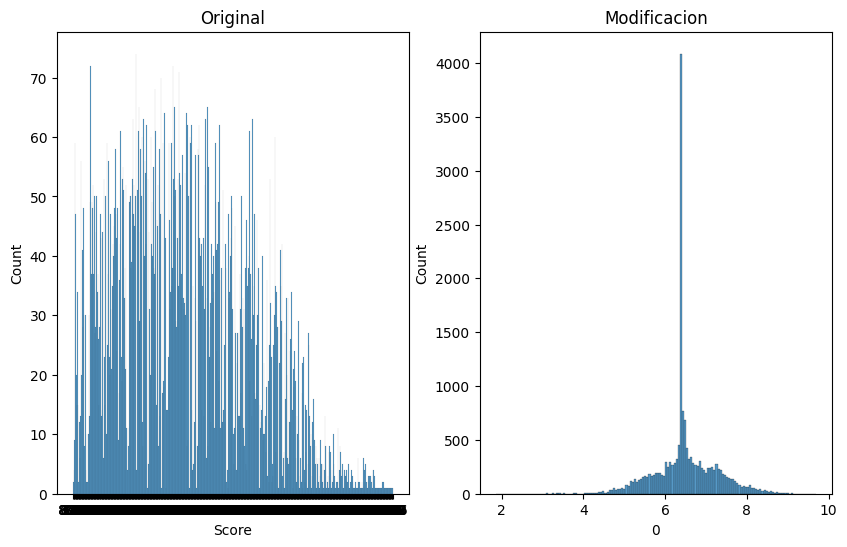

In [169]:
# Verificar si cambiamos distribucion
plt.figure(figsize=(10,6)) 
plt.subplot(121)
sns.histplot(data2['Score'])
plt.title('Original')
plt.subplot(122)
sns.histplot(data2fillDF[0])
plt.title('Modificacion')

Es muy diferente la distribución. Este llenado no es viable. 

In [252]:
data2.tail(4)

,Name,Score,Duration,Episodes,Watching,Completed,On-Hold,Dropped
17558,Mieruko-chan,NaN,NaN,NaN,14.0,NaN,14.0,NaN
17559,Higurashi no Naku Koro ni Sotsu,NaN,NaN,NaN,3.0,NaN,NaN,NaN
17560,Yama no Susume: Next Summit,NaN,NaN,NaN,13.0,2.0,2.0,1.0
17561,Scarlet Nexus,NaN,NaN,NaN,4.0,NaN,1.0,1.0


Probemos ahora con imputación multiple KNN

Text(0.5, 1.0, 'Modificacion')

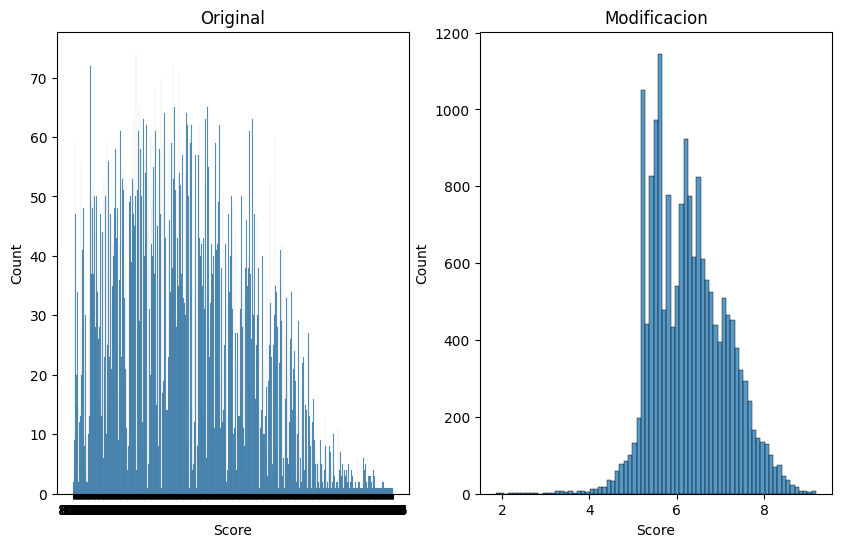

In [239]:
imputer = KNNImputer(n_neighbors= 3).set_output(transform='pandas')
data2f = imputer.fit_transform(data2.drop('Name', axis=1))

# Verificar si cambiamos distribucion
plt.figure(figsize=(10,6)) 
plt.subplot(121)
sns.histplot(data2['Score'])
plt.title('Original')
plt.subplot(122)
sns.histplot(data2f['Score'])
plt.title('Modificacion')

Es más coherente que el anterior. 

In [245]:
data2f['Name'] = data2['Name']

In [251]:
data2f.tail(4)

,Score,Duration,Episodes,Watching,Completed,On-Hold,Dropped,Name
17558,5.676667,2140.000000,425.333333,14.0,132.666667,14.000000,57.000000,Mieruko-chan
17559,5.993333,17.000000,1.000000,3.0,33.666667,2.666667,19.666667,Higurashi no Naku Koro ni Sotsu
17560,5.493333,130.666667,4.000000,13.0,2.000000,2.000000,1.000000,Yama no Susume: Next Summit
17561,6.563333,9.000000,1.000000,4.0,24.666667,1.000000,1.000000,Scarlet Nexus


Ahora tenemos el dataframe de la segunda linea sin valores nulos. Listo para pasar a los Outliers

In [253]:
#Imputación multiple para la primera linea